In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from scipy.optimize import differential_evolution
import timm

# ------------------------
# 1. Define Classes
# ------------------------
CLASSES = [
    "No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax", "Consolidation",
    "Edema", "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
]

# ------------------------
# 2. Load and Preprocess Data
# ------------------------
df = pd.read_csv("/student/csc490_project/shared/labels.csv")
df["label_list"] = df["Finding Labels"].apply(lambda x: x.split("|"))

mlb = MultiLabelBinarizer(classes=CLASSES)
labels_array = mlb.fit_transform(df["label_list"])
df["labels"] = list(labels_array)

unique_patients = df["Patient ID"].unique()
np.random.seed(42)
np.random.shuffle(unique_patients)
train_end = int(0.7 * len(unique_patients))
val_end = int(0.8 * len(unique_patients))

train_patients = unique_patients[:train_end]
val_patients = unique_patients[train_end:val_end]
test_patients = unique_patients[val_end:]

test_df = df[df["Patient ID"].isin(test_patients)].reset_index(drop=True)

# ------------------------
# 3. Dataset Class
# ------------------------
class ChestXrayDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]["Image Index"])
        image = Image.open(img_path).convert("L")
        labels = torch.tensor(self.df.iloc[idx]["labels"], dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        return image, labels

# ------------------------
# 4. Transforms & Loaders
# ------------------------
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_dir = "/student/csc490_project/shared/preprocessed_images/preprocessed_images"
test_dataset = ChestXrayDataset(test_df, img_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# ------------------------
# 5. Load Models
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    'maxvit': timm.create_model('maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k', pretrained=False, num_classes=15),
    'densenet': timm.create_model('densenet121', pretrained=False, num_classes=15),
    'coatnet': timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=False, num_classes=15),
    'swin': timm.create_model('swin_large_patch4_window7_224', pretrained=False, num_classes=15),
    'convnext': timm.create_model('convnext_large.fb_in22k', pretrained=False, num_classes=15),
    'vgg19': timm.create_model('vgg19.tv_in1k', pretrained=False, num_classes=15)
}

models['maxvit'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k_model.pth'))
models['densenet'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_densenet121_model.pth'))
models['coatnet'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_coatnet_2_rw_224.sw_in12k_ft_in1k_model.pth'))
models['swin'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_swin_large_patch4_window7_224_model.pth'))
models['convnext'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_convnext_large.fb_in22k_model.pth'))
models['vgg19'].load_state_dict(torch.load('/student/csc490_project/shared/new_split_models/no_augment_vgg19.tv_in1k_model.pth'))

for model in models.values():
    model.to(device)
    model.eval()

# ------------------------
# 6. Collect Test Predictions
# ------------------------
def collect_predictions(loader):
    all_preds = {name: [] for name in models}
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            for name, model in models.items():
                all_preds[name].append(torch.sigmoid(model(images)).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = {k: np.concatenate(v) for k, v in all_preds.items()}
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

test_preds, test_labels = collect_predictions(test_loader)




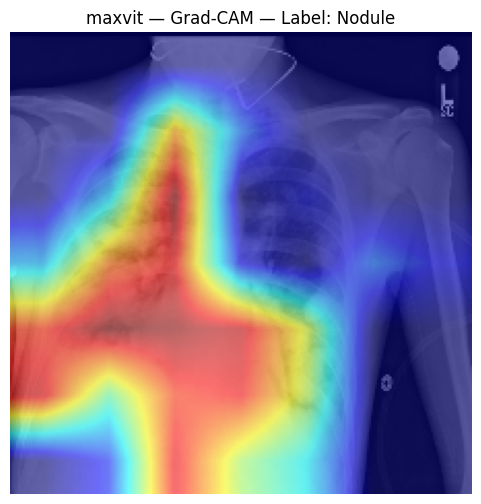

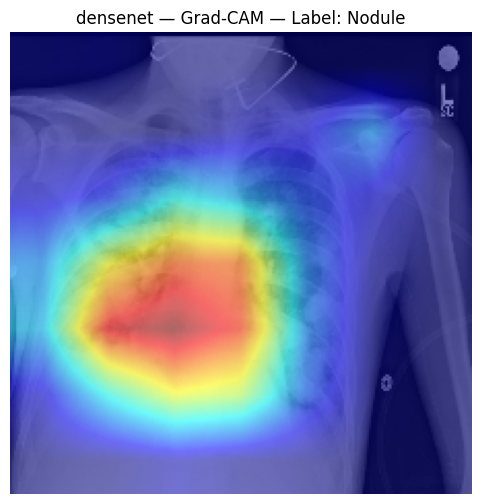

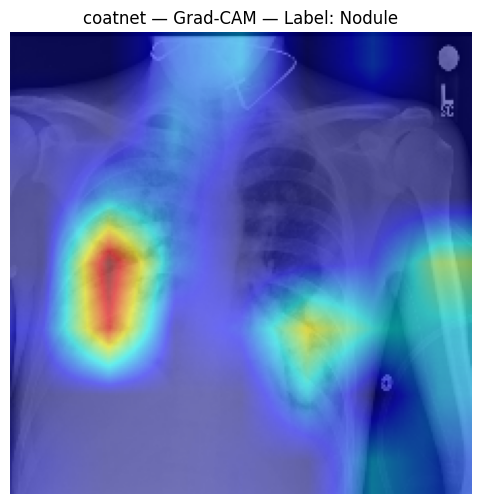

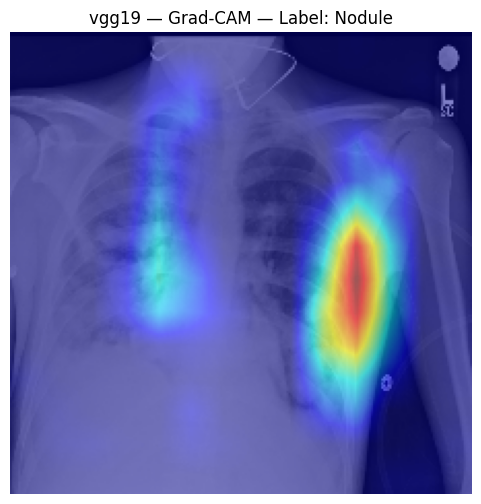

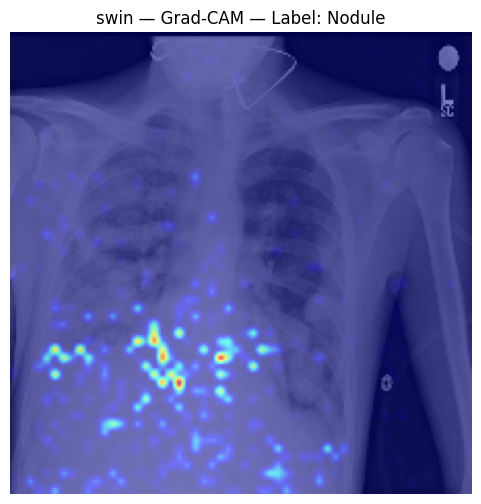

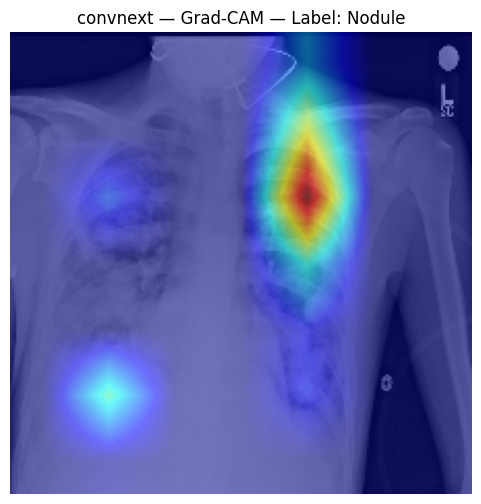

Sample 1/1 — Test Index: 3810 — True Label: Nodule
Ensemble Prediction (binary): [[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
Predicted Class Labels: ['Nodule']
Top-1 Predicted Label (raw):
Nodule: 0.3381
Per-sample F1 Score: 1.0000


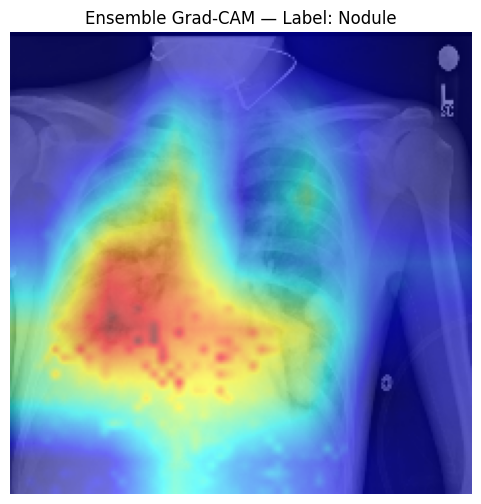

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import f1_score
import os

# Model combo and weights
best_models = ['maxvit', 'densenet', 'coatnet', 'vgg19', 'swin', 'convnext']
best_weights = [0.2707, 0.1911, 0.1496, 0.0360, 0.1412, 0.2114]

# ChestX-ray14 labels
class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
               'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
               'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def normalize_cam(cam):
    return (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

def get_target_layer(model, model_name):
    if model_name == 'maxvit':
        return model.stages[-1].blocks[-1]
    elif model_name == 'densenet':
        return model.get_submodule("features.denseblock4.denselayer16.conv2")
    elif model_name == 'coatnet':
        return list(model.stages[-1].children())[-1]
    elif model_name == 'vgg19':
        return model.get_submodule("features.35")
    elif model_name == 'swin':
        return model.patch_embed.proj
    elif model_name == 'convnext':
        return list(model.stages[3].blocks.children())[-1].conv_dw
    else:
        raise ValueError(f"Target layer not defined for {model_name}")

def get_predicted_labels(outputs, threshold=0.1):
    preds = (outputs > threshold).int().cpu().numpy()
    return preds

def multilabel_binarize(label_str, class_list):
    label_vector = np.zeros(len(class_list), dtype=int)
    for label in label_str.split('|'):
        if label in class_list:
            label_vector[class_list.index(label)] = 1
    return label_vector

# Output directory
os.makedirs("cam_outputs", exist_ok=True)

# Manually selected test indices
sample_indices = [3810]

for idx, sample_idx in enumerate(sample_indices):
    sample_row = test_df.iloc[sample_idx]
    img_path = os.path.join(img_dir, sample_row["Image Index"])
    true_label = sample_row["Finding Labels"]

    original_image = Image.open(img_path).convert("RGB")
    resized_image = original_image.resize((224, 224))
    image_np = np.array(resized_image).astype(np.float32) / 255.0
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    individual_cams = {}
    model_outputs = []

    # Run each model
    for i, model_name in enumerate(best_models):
        weight = best_weights[i]
        model = models[model_name]
        model.eval()

        target_layer = get_target_layer(model, model_name)
        cam_method = LayerCAM if model_name == "swin" else GradCAM
        cam = cam_method(model=model, target_layers=[target_layer])

        grayscale_cam = cam(input_tensor=input_tensor)[0]
        grayscale_cam = cv2.resize(grayscale_cam, (224, 224))
        normalized_cam = normalize_cam(grayscale_cam)
        cam_image = show_cam_on_image(image_np, normalized_cam, use_rgb=True)

        individual_cams[model_name] = normalized_cam * weight

        with torch.no_grad():
            output = model(input_tensor)
            model_outputs.append(weight * output)

        # ✅ Save and show each individual Grad-CAM
        plt.figure(figsize=(6, 6))
        plt.imshow(cam_image)
        plt.title(f"{model_name} — Grad-CAM — Label: {true_label}")
        plt.axis("off")
        save_path = f"cam_outputs/sample_{sample_idx}_{idx}_{model_name}_cam.png"
        plt.savefig(save_path)
        plt.show()

    # Final Ensemble Grad-CAM
    ensemble_cam = sum(individual_cams.values()) / sum(best_weights)
    ensemble_cam = normalize_cam(ensemble_cam)
    ensemble_cam_image = show_cam_on_image(image_np, ensemble_cam, use_rgb=True)

    # Ensemble Prediction
    ensemble_output = sum(model_outputs) / sum(best_weights)
    predicted_labels = get_predicted_labels(ensemble_output, threshold=0.3)

    # Fallback to "No Finding"
    if np.sum(predicted_labels) == 0:
        predicted_labels[0][-1] = 1

    # True label vector
    true_vector = multilabel_binarize(true_label, class_names)

    # Per-sample F1 score
    f1 = f1_score(true_vector, predicted_labels[0], average='macro')

    if f1 > 0:
        print(f"Sample {idx + 1}/{len(sample_indices)} — Test Index: {sample_idx} — True Label: {true_label}")
        print(f"Ensemble Prediction (binary): {predicted_labels}")
        predicted_indices = np.where(predicted_labels[0] == 1)[0]
        predicted_classes = [class_names[i] for i in predicted_indices]
        print(f"Predicted Class Labels: {predicted_classes}")

        # Top-1 class prediction
        top1_idx = torch.argmax(ensemble_output[0]).item()
        top1_class = class_names[top1_idx]
        top1_score = float(ensemble_output[0][top1_idx])
        print("Top-1 Predicted Label (raw):")
        print(f"{top1_class}: {top1_score:.4f}")

        print(f"Per-sample F1 Score: {f1:.4f}")

        # Save and show ensemble Grad-CAM
        plt.figure(figsize=(6, 6))
        plt.imshow(ensemble_cam_image)
        plt.title(f"Ensemble Grad-CAM — Label: {true_label}")
        plt.axis("off")
        plt.savefig(f"cam_outputs/sample_{sample_idx}_{idx}_ensemble.png")
        plt.show()
    else:
        print(f"Sample {sample_idx}: F1 = {f1:.4f} — skipping (incorrect prediction)")


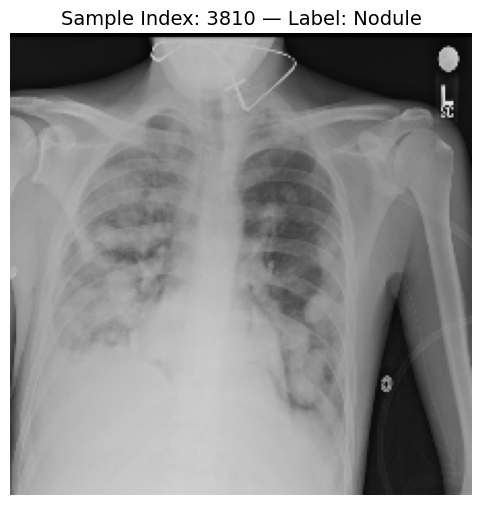

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

sample_idx = 3810
sample_row = test_df.iloc[sample_idx]
img_path = os.path.join(img_dir, sample_row["Image Index"])
true_label = sample_row["Finding Labels"]

original_image = Image.open(img_path).convert("RGB")
resized_image = original_image.resize((224, 224))

plt.figure(figsize=(6, 6))
plt.imshow(resized_image)
plt.title(f"Sample Index: {sample_idx} — Label: {true_label}", fontsize=14)
plt.axis("off")
plt.show()
